# Xai Project: Evaluating Explainability
In this work we fine-tuned VGG-16 for a binary task, exploiting the "Cars and Bikes" image classification dataset. We then evaluated a set of explainability methods using the Captum library. We will use primarly Grounded SAM model to segment the image and extract the patches of each image.

In [83]:
from datetime import datetime
# Enable it for DEMO
import warnings
warnings.filterwarnings("ignore")
start_notebook_time = datetime.now() #for time lenght of the whole notebook

In [84]:
!pip install captum
!pip install autodistill-grounded-sam autodistill-yolov8
!pip install roboflow

In [85]:
from autodistill_grounded_sam import GroundedSAM
from autodistill.detection import CaptionOntology
from autodistill.utils import plot

bike_parts = ["handlebar", "wheel", "seat", "engine", "headlight", "brake", "exhaust"]
car_parts = ["wheel", "door", "window", "headlight", "bumper", "hood", "trunk"]


# Bike: caption is "bike wheel" → label is "wheel"
ontology_bike = CaptionOntology({f"bike {part}": part for part in bike_parts})

# Car: caption is "car wheel" → label is "wheel"
ontology_car = CaptionOntology({f"car {part}": part for part in car_parts})

# Pre-initialize both models
sam_bike = GroundedSAM(ontology=ontology_bike)
sam_car = GroundedSAM(ontology=ontology_car)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


In [86]:
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset, DataLoader, Subset, random_split
import torch
import os

# Number of samples to explain
n_samples_to_explain = 20

# Custom class to also return image paths
class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        path = self.samples[index][0]
        return img, label, path

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset path
dataset_root = '/kaggle/input/car-vs-bike-classification-dataset/Car-Bike-Dataset'

# 1. Data transformations
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                [0.229, 0.224, 0.225])  # ImageNet std
])

# 2. Load dataset with path support
full_dataset = ImageFolderWithPaths(root=dataset_root, transform=transform)

# 3. Split into train and test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# 4. DataLoaders
if not os.path.exists("/kaggle/input/pre-computations/best_model_vgg_CarVsBike.pth"):
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 5. Pick samples to explain from each class
# Get class indices (e.g., 0 = Bike, 1 = Car)
bike_indices = [i for i, (_, label, _) in enumerate(test_dataset) if label == 0][:n_samples_to_explain // 2]
car_indices  = [i for i, (_, label, _) in enumerate(test_dataset) if label == 1][-n_samples_to_explain // 2:]

bike_subset = Subset(test_dataset, bike_indices)
car_subset = Subset(test_dataset, car_indices)

# 6. Combine subsets and create DataLoader
merged_dataset = ConcatDataset([bike_subset, car_subset])
subset_loader = DataLoader(merged_dataset, batch_size=1, shuffle=False)


## Vgg-16 Fine-Tuning

In [87]:
import os

vgg_path = "/kaggle/input/pre-computations/best_model_vgg_CarVsBike.pth"

if os.path.exists(vgg_path):
    print("Pretrained VGG-16 model already available. Skipping fine-tuning.")
else:
    print("No pretrained model found. Starting fine-tuning of VGG-16...")
    
    from torchvision import datasets, models
    from torch import nn, optim

    model = models.vgg16(pretrained=True)

    # Freeze convolutional layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace classifier for binary classification
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 2)
    )

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0005)

    # Training loop
    best_accuracy = 0.0
    for epoch in range(20):
        model.train()
        running_loss = 0.0
        correct = 0

        for images, labels, _ in train_dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()

        train_accuracy = correct / len(train_dataset)
        print(f"Epoch {epoch+1}/20 — Train Acc: {train_accuracy:.4f}")

        # Eval su test
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, _ in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        test_accuracy = correct / total
        print(f"Test Accuracy: {test_accuracy:.4f}")
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), "/kaggle/working/best_model_vgg_CarVsBike.pth")


Pretrained VGG-16 model already available. Skipping fine-tuning.


## Medoid Computations
For each class we compute the medoid, which is the sample that best represent all the others belonging to the same class.

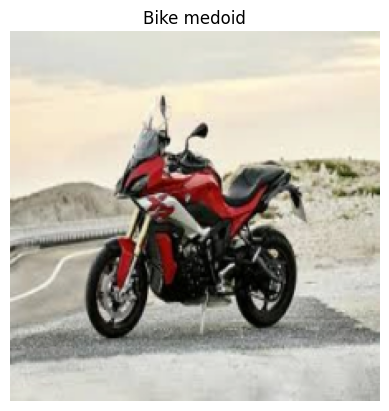

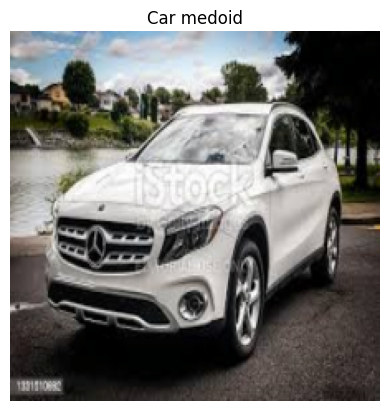

In [101]:
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision.datasets import CIFAR10
from torchvision import models


if not os.path.exists("/kaggle/input/pre-computations/medoid_bike.png") and not os.path.exists("/kaggle/input/pre-computations/medoid_bike.png"):
    
    for medoid_class in ["bike", "car"]:
        # Device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load pretrained model (feature extractor)
        model_medoid = models.resnet50(pretrained=True)
        model_medoid.fc = torch.nn.Identity()  # rimuove l'ultimo strato per ottenere feature
        model_medoid = model_medoid.to(device).eval()
        
        # Pick one image
        model_medoid.eval()
        # Transformation
        transform = T.Compose([
            T.Resize(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],  # standard ImageNet normalization
                        std=[0.229, 0.224, 0.225])
        ])
        
        class_names = test_dataset.dataset.classes
        
        if medoid_class=="bike":
            target_class = 0
        else:
            target_class = 1
        
        idxs = [i for i, (_, label, _) in enumerate(test_dataset) if label == target_class]
        subset = Subset(test_dataset, idxs)
        loader = DataLoader(subset, batch_size=32, shuffle=False)
        
        # Extract features for each image
        features = []
        images = []
        
        with torch.no_grad():
            for x, _, _ in loader:
                x = x.to(device)
                feats = model_medoid(x).cpu().numpy()
                features.append(feats)
                images.append(x.cpu())
        
        features = np.concatenate(features, axis=0)
        images = torch.cat(images, dim=0)
        
        # Pair-wise matrix
        dists = pairwise_distances(features, metric='euclidean')
        
        # Calculate medoid (minima distanza media)
        mean_dists = dists.mean(axis=1)
        medoid_idx = np.argmin(mean_dists)
        
        # Visualise Medoid
        unnormalize = T.Normalize(mean=[-m/s for m, s in zip([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])],
                                  std=[1/s for s in [0.229, 0.224, 0.225]])
        
        medoid_img = unnormalize(images[medoid_idx]).permute(1, 2, 0).numpy()
        medoid_img = np.clip(medoid_img, 0, 1)
        
        plt.imshow(medoid_img)
        plt.axis("off")
        plt.title(f"{class_names[target_class]} medoid")
        plt.show()
        
        plt.imsave(f"medoid_{medoid_class}.png", medoid_img)

else:
    for img_path in ["/kaggle/input/pre-computations/medoid_bike.png", "/kaggle/input/pre-computations/medoid_car.png"]:
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        title_str = "Bike medoid" if "bike" in img_path else "Car medoid"
        plt.title(f"{title_str}")
        plt.axis("off")
        plt.show()

## Gradient-based methods
We adopted Captum as a library to explain the model.

In [ ]:
from captum.attr import IntegratedGradients, Saliency, Occlusion, LayerGradCam, InputXGradient, GuidedBackprop
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

#Traform in numpy image 
def unnormalize(img_tensor, mean, std):
    if isinstance(mean, torch.Tensor):
        mean = mean.tolist()
    if isinstance(std, torch.Tensor):
        std = std.tolist()

    img = img_tensor.clone().detach().cpu().numpy()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return np.clip(img.transpose(1, 2, 0), 0, 1)

def compute_gradient_methods(model, image, predicted_class, show=False, use_absolute=False):
    attributions_gray = {}
    timings = {}

    input_tensor = image.to(device)
    
    # Funzione di unnormalize per visualizzare
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    
    
    orig_np = unnormalize(image.squeeze(0), mean, std)

    
    # GradCAM layer
    gradcam_layer = model.features[-1]  # or model.features[29]

    # GuidedBackprop (per Guided GradCAM) 
    start_guided = time.time()
    guided_bp = GuidedBackprop(model).attribute(input_tensor, target=predicted_class)

    # GradCAM 
    start = time.time()
    layer_gc = LayerGradCam(model, gradcam_layer).attribute(input_tensor, target=predicted_class)
    timings["GradCAM"] = time.time() - start

    # Upsample + Guided GradCAM
    layer_gc_upsampled = torch.nn.functional.interpolate(
        layer_gc, size=(224, 224), mode='bilinear', align_corners=False
    )
    guided_gradcam = guided_bp * layer_gc_upsampled
    timings["Guided GradCAM"] = time.time() - start_guided

    # Altri metodi ---
    methods = {}

    start = time.time()
    methods["Integrated Gradients"] = IntegratedGradients(model).attribute(input_tensor, target=predicted_class, n_steps=100,internal_batch_size=8)
    timings["Integrated Gradients"] = time.time() - start

    start = time.time()
    methods["Saliency"] = Saliency(model).attribute(input_tensor, target=predicted_class)
    timings["Saliency"] = time.time() - start

    start = time.time()
    methods["Occlusion"] = Occlusion(model).attribute(
        input_tensor, strides=(1, 3, 3), target=predicted_class,
        sliding_window_shapes=(1, 15, 15), baselines=0)
    timings["Occlusion"] = time.time() - start

    start = time.time()
    methods["Input × Gradient"] = InputXGradient(model).attribute(input_tensor, target=predicted_class)
    timings["Input × Gradient"] = time.time() - start

    methods["GradCAM"] = layer_gc
    methods["Guided GradCAM"] = guided_gradcam

    if show:
        fig, axs = plt.subplots(1, len(methods) + 1, figsize=(15, 5))
        axs[0].imshow(orig_np)
        axs[0].set_title("Original")
        axs[0].axis("off")

    for i, (name, attr) in enumerate(methods.items(), start=1):
        attr_np = attr.squeeze().detach().cpu().numpy()
        
        if attr_np.ndim == 3:
            attr_gray = np.sum(attr_np, axis=0) if not use_absolute else np.sum(np.abs(attr_np), axis=0)
        else:
            attr_gray = attr_np if not use_absolute else np.abs(attr_np)

        attr_vis = (attr_gray - attr_gray.min()) / (attr_gray.max() - attr_gray.min() + 1e-8)
        attributions_gray[name] = attr_gray

        if show:
            axs[i].imshow(orig_np, alpha=0.3)
            axs[i].imshow(attr_gray, cmap="seismic", alpha=0.7, vmin=-np.max(np.abs(attr_gray)), vmax=np.max(np.abs(attr_gray)))
            axs[i].set_title(name)
            axs[i].axis("off")

    if show:
        plt.tight_layout()
        plt.show()

    return attributions_gray, timings

## LIME computation

In [90]:
import numpy as np
from skimage.segmentation import mark_boundaries
from captum._utils.models.linear_model import SkLearnLinearRegression
from captum.attr import Lime
from captum.attr import visualization as viz
import torch
import matplotlib.pyplot as plt

def compute_LIME(model, image_to_explain, class_predicted, feature_masks, show=False, use_absolute=False): 

    unnormalize = T.Normalize(mean=[-m/s for m, s in zip([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])],std=[1/s for s in [0.229, 0.224, 0.225]])
    orig_np = unnormalize(image_to_explain[0]).permute(1, 2, 0).cpu().numpy()
    orig_np = np.clip(orig_np, 0, 1)
    
    # 1. Construct feature_masks from Grounded-SAM
    H, W = feature_masks[0].shape
    feature_mask = np.zeros((H, W), dtype=np.int32)
    
    for idx, mask in enumerate(feature_masks):
        feature_mask[mask] = idx + 1  # background resta 0
    
    # Resize feature_mask a 224x224 to matchare orig_np
    feature_mask_resized = cv2.resize(feature_mask, (224, 224), interpolation=cv2.INTER_NEAREST)
    if show:
        # 2. Visualizza masks of Grounded-SAM
        plt.figure(figsize=(6, 6))
        plt.imshow(mark_boundaries(orig_np, feature_mask_resized))
        plt.title("LIME SAM segmentation")
        plt.axis("off")
        plt.show()
        
        print("Feature IDs:", np.unique(feature_mask).tolist())
        print("Feature mask shape:", feature_mask.shape)
        
    # 3.LIME
    lr_lime = Lime(model, interpretable_model=SkLearnLinearRegression())
    
    feature_mask_tensor = torch.tensor(feature_mask_resized).unsqueeze(0).to(device)

    start = time.time()
    lime_attr = lr_lime.attribute(
        image_to_explain,
        target=class_predicted,
        feature_mask=feature_mask_tensor
    ).squeeze(0)
    duration = time.time() - start

    if show:
        # 4. Visualize
        print('Attribution range:', lime_attr.min().item(), 'to', lime_attr.max().item())
        
        _ = viz.visualize_image_attr_multiple(
            lime_attr.permute(1, 2, 0).detach().cpu().numpy(),  # shape [H,W,C]
            orig_np,
            ["original_image", "blended_heat_map", "blended_heat_map", "masked_image"],
            ["all", "positive", "negative", "positive"],
            titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"])
    

    lime_attr_np = lime_attr.detach().cpu().numpy()
    
    if lime_attr_np.ndim == 3:
        if use_absolute:
            attr_gray = np.sum(np.abs(lime_attr_np), axis=0)
        else:
            attr_gray = np.sum(lime_attr_np, axis=0)
    else:
        attr_gray = np.abs(lime_attr_np) if use_absolute else lime_attr_np
    
    if attr_gray.shape != (224, 224):
        attr_gray = cv2.resize(attr_gray, (224, 224), interpolation=cv2.INTER_LINEAR)
    
    return attr_gray, duration

## SHAP computation

In [91]:
from captum.attr import KernelShap
from skimage.segmentation import mark_boundaries
from captum._utils.models.linear_model import SkLearnLinearRegression
from captum.attr import visualization as viz


def compute_SHAP(model, image_to_explain, class_predicted, feature_masks, show=False, use_absolute=False):
    
    orig_np = unnormalize(image_to_explain[0], mean, std)

    # Costruct feature_masks Grounded-SAM
    H, W = feature_masks[0].shape
    feature_mask = np.zeros((H, W), dtype=np.int32)
    
    for idx, mask in enumerate(feature_masks):
        feature_mask[mask] = idx + 1  # background resta 0
    
    # Resize la feature_mask a 224x224 to matchare orig_np
    feature_mask_resized = cv2.resize(feature_mask, (224, 224), interpolation=cv2.INTER_NEAREST)

    if show:
        # Visualize Grounded-SAM
        plt.figure(figsize=(6, 6))
        plt.imshow(mark_boundaries(orig_np, feature_mask_resized))
        plt.title("Kernel SHAP SAM segmentation")
        plt.axis("off")
        plt.show()
        
    # KernelSHAP 
    ks_model = KernelShap(model)
    
    start = time.time()
    ks_attr = ks_model.attribute(
        image_to_explain,
        target=class_predicted,
        n_samples=100,
        feature_mask=torch.tensor(feature_mask_resized).unsqueeze(0).to(device)
    ).squeeze(0)
    duration = time.time() - start

    if show:
        attr_np = ks_attr.detach().cpu().numpy()
        min_val = attr_np.min()
        max_val = attr_np.max()
        print(f'Attribution range: {min_val:.6f} to {max_val:.6f}')
        
        # Check if the attribution is flat
        if np.abs(max_val - min_val) < 1e-6:
            print("Attribution map is flat (no variation). Skipping visualization.")
        else:
            _ = viz.visualize_image_attr_multiple(
                ks_attr.permute(1, 2, 0).detach().cpu().numpy(),  # shape: [H, W, C]
                orig_np,
                ["original_image", "blended_heat_map", "blended_heat_map", "masked_image"],
                ["all", "positive", "negative", "positive"],
                titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"]
            )

    
    ks_attr_np = ks_attr.detach().cpu().numpy()
    
    if ks_attr_np.ndim == 3:
        attr_gray = np.sum(ks_attr_np, axis=0) if not use_absolute else np.sum(np.abs(ks_attr_np), axis=0)
    else:
        attr_gray = ks_attr_np if not use_absolute else np.abs(ks_attr_np)

        
    if attr_gray.shape != (224, 224):
        attr_gray = cv2.resize(attr_gray, (224, 224), interpolation=cv2.INTER_LINEAR)
    return attr_gray, duration

## Filtered Masks function

This function selects just the masks that are necessary to maintain the semantics of the image. All the masks are complementary: they do not overlap.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from collections import defaultdict



def show_masks_on_image(base_image, masks, labels, title, label_colors=None):
    H, W = base_image.shape[:2]
    H, W = base_image.shape[:2]
    overlay = np.ones((H, W, 3), dtype=np.uint8) * 255  # sfondo bianco RGB


    for mask, label in zip(masks, labels):
        # Resize of masks to match image dimensions 
        resized_mask = cv2.resize(mask.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST).astype(bool)
        color = label_colors[label]
        for c in range(3):
            overlay[:, :, c][resized_mask] = color[c]

    plt.imshow(overlay.astype(np.uint8))
    plt.axis("off")
    plt.title(title)
    plt.show()

def show_masks_individually(masks, labels, image_rgb, title_prefix="", id_to_label=None, label_colors=None):

    H, W = image_rgb.shape[:2]

    for i, (mask, label) in enumerate(zip(masks, labels)):
        resized = cv2.resize(mask.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST).astype(bool)

        overlay = np.ones((H, W, 3), dtype=np.uint8) * 255

        if isinstance(label, str) or id_to_label is None:
            label_str = str(label)
        else:
            label_str = id_to_label.get(label, str(label))

        color_key = label_str
        color = label_colors.get(color_key, np.array([0, 0, 0]))  # fallback nero

        # Apply masks
        for c in range(3):
            overlay[:, :, c][resized] = color[c]

        plt.imshow(overlay)
        plt.title(f"{title_prefix}Mask {i+1} — {label_str}")
        plt.axis("off")
        plt.show()


def calculate_filtered_masks(img_path, results, id_to_label, show=False):

    image_bgr = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    image_rgb = cv2.resize(image_rgb, (224, 224), interpolation=cv2.INTER_AREA)
    
    unique_labels = list(set(results.class_id))
    label_colors = {label: np.random.randint(0, 255, size=3) for label in unique_labels}
    
    #  1. Show original masks
    original_masks = results.mask         # [N, H, W]
    original_labels = results.class_id    # [N]
    #show_masks_on_image(image_rgb, original_masks, original_labels, "Maschere originali da Grounded-SAM")
    
    #  2. Filtraggio intra-classe 
    masks_by_class = defaultdict(list)
    for mask, label in zip(original_masks, original_labels):
        masks_by_class[label].append(mask) #-> "ear": [mask_ear1, mask_ear2, mask_ear3, ...],
    
    filtered_masks = []
    filtered_labels = []
    
    for label, class_masks in masks_by_class.items():
        accepted = []
        total_mask = np.zeros_like(class_masks[0], dtype=bool)
        class_masks = sorted(class_masks, key=lambda m: m.sum()) #dalla più piccola alla più grande
        for mask in class_masks:
            if not np.any(np.logical_and(total_mask, mask)): #Se non si sovrappone con nulla già accettato
                accepted.append(mask)
                total_mask |= mask
        filtered_masks.extend(accepted)
        filtered_labels.extend([label] * len(accepted))
    
    # Show filtered masks intra-classe
    #show_masks_on_image(image_rgb, filtered_masks, filtered_labels, "Maschere filtrate intra-classe (più piccole, no overlap nella stessa classe)", label_colors)
    
    #  3. Remove overlap inter-classe 
    final_masks = filtered_masks.copy()
    final_labels = filtered_labels.copy()
    
    n = len(final_masks)
    
    kernel = np.ones((3, 3), np.uint8)
    
    for i in range(n):
        for j in range(i + 1, n):
            if final_labels[i] != final_labels[j]:
                mask_i = final_masks[i]
                mask_j = final_masks[j]
    
                area_i = mask_i.sum()
                area_j = mask_j.sum()
    
                if area_i < area_j:
                    smaller_mask = cv2.dilate(mask_i.astype(np.uint8), kernel, iterations=1).astype(bool)
                    intersection = np.logical_and(smaller_mask, mask_j)
                    
                    if intersection.sum() > 0:
                        final_masks[j] = np.logical_and(mask_j, ~intersection)
                        final_masks[i]=smaller_mask
                else:
                    smaller_mask = cv2.dilate(mask_j.astype(np.uint8), kernel, iterations=1).astype(bool)
                    intersection = np.logical_and(mask_i, smaller_mask)
                    if intersection.sum() > 0:
                        final_masks[i] = np.logical_and(mask_i, ~intersection)
                        final_masks[j]=smaller_mask

    
    filtered_final_masks = []
    filtered_final_labels = []
    for mask, label in zip(final_masks, final_labels):
        if mask.sum() > 10:
            filtered_final_masks.append(mask)
            filtered_final_labels.append(label)

    
    # Show final masks 
    if show:
        show_masks_on_image(image_rgb, filtered_final_masks, filtered_final_labels, "All final masks", label_colors)

    #id_to_label = base_model.ontology.classes() 
    # Se base_model.ontology.classes() è una lista:
    if isinstance(id_to_label, list):
        id_to_label = {i: name for i, name in enumerate(id_to_label)}
    
    # 1. Cumulative mask for background
    H, W = filtered_final_masks[0].shape
    total_mask = np.zeros((H, W), dtype=bool)
    
    for mask in filtered_final_masks:
        total_mask |= mask 
        
    total_mask_dilated = cv2.dilate(total_mask.astype(np.uint8), kernel, iterations=1).astype(bool)#fix bg
    
    background_mask = ~total_mask
    
    # 3. Remove rumore troppo piccolo
    if background_mask.sum() < 5:
        print("Background troppo piccolo, non aggiunto.")
    else:
        next_id = max(id_to_label.keys()) + 1
        
        # Add "background" with new ID
        id_to_label[next_id] = "background"
        
        filtered_final_labels.append(next_id)
        filtered_final_masks.append(background_mask)
    
    if show:
        #show_masks_individually(original_masks, original_labels, title_prefix="ORIG - ", id_to_label=id_to_label, label_colors=label_colors)
        #print("-"*100)
        #show_masks_individually(filtered_masks, filtered_labels, title_prefix="FILTERED - ", id_to_label=id_to_label, label_colors=label_colors)
        print("-"*100)
        show_masks_individually(filtered_final_masks, filtered_final_labels, image_rgb, title_prefix="FINAL - ", id_to_label=id_to_label, label_colors=label_colors)



    print(f'Final masks for this instance are: {len(filtered_final_masks)}')
    return filtered_final_masks, filtered_final_labels, id_to_label


## Rank masks
The following function sorts the attributions assigned to patches (extracted by Grounded SAM) in decremental order.

In [93]:

def sort_masks(attributions, filtered_final_masks, filtered_final_labels, id_to_label, show=False):
    # Calcola e stampa ranking per ogni metodo Captum
    sorted_masks_by_method = {}
    
    for method_name, attr_gray in attributions.items():
        # Resize 
        if attr_gray.shape != (224, 224):
            attr_gray = cv2.resize(attr_gray, (224, 224), interpolation=cv2.INTER_LINEAR)
        mask_scores = []
        for i, (mask, label) in enumerate(zip(filtered_final_masks, filtered_final_labels)):
            resized_mask = cv2.resize(mask.astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)
            mask_area = resized_mask.sum()
            if mask_area == 0:
                score = 0
            else:
                score = attr_gray[resized_mask].sum() / mask_area
            mask_scores.append((i, score, label))
        sorted_masks = sorted(mask_scores, key=lambda x: x[1], reverse=True)
        sorted_masks_by_method[method_name] = sorted_masks # Used also later for insertion curve

        if show:
            print(f"\n Top masks by mean score for: {method_name}")
            for rank, (i, score, label) in enumerate(sorted_masks):                
                label_name = id_to_label[label]
                print(f"Rank {rank+1}: Mask {i} → Label: '{label_name}' | Score = {score:.4f}")
    return sorted_masks_by_method

## Feature removal visualization

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def feature_removal_visualization(image_to_explain, sorted_masks_by_method, medoid_class, filtered_final_masks, id_to_label):
    
    for method_name, sorted_masks in sorted_masks_by_method.items():
        print()
        print("-"*40)
        print(f"\nVisualizing step-by-step for the method: {method_name}")
        mean = [0.485, 0.456, 0.406]
        std  = [0.229, 0.224, 0.225]
        orig_np = unnormalize(image_to_explain[0], mean, std)
        
        modified_image = orig_np.copy()
    
        # Load the correct medoid
        if medoid_class == "bike":
            bgr = cv2.imread("/kaggle/input/pre-computations/medoid_bike.png")
        else:
            bgr = cv2.imread("/kaggle/input/pre-computations/medoid_car.png")
    
        medoid = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        assert medoid.shape == modified_image.shape, "Shape mismatch between images!"
    
        # 5 masks
        for i, (index, score, label) in enumerate(sorted_masks):
            mask = cv2.resize(filtered_final_masks[index].astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)
    
            # Applly medoid
            for c in range(3):  # R, G, B channels
                modified_image[mask, c] = medoid[mask, c]
            print(f"Label {label} is {id_to_label[label]}, id_to_label has len: {len(id_to_label)}")
            label_name = id_to_label[label]
    
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            axs[0].imshow(modified_image)
            axs[0].set_title(f"{method_name} - Step {i+1}: Replaced '{label_name}'")
            axs[0].axis('off')
    
            axs[1].imshow(mask, cmap='gray')
            axs[1].set_title(f"Mask of '{label_name}'")
            axs[1].axis('off')
    
            plt.tight_layout()
            plt.show()

## Effective Compactness

In [95]:
import torch
from torchvision import transforms as T
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Parameters
use_softmax = True     
threshold = 0.5  #Used if softmax is True


transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

def compute_EC(original_label, original_prob, sorted_masks_by_method, image_to_explain, model, medoid_class, original_class, show=False):

    if show:
        print(f" Class originally assigned: {original_label}")
        print(f" Initial probability: {original_prob}\n")

    
    orig_np = unnormalize(image_to_explain[0], mean, std)

    method_to_ec = {}
    
    for method_name, sorted_masks in sorted_masks_by_method.items():
        if show:
            print(f"\n Method: {method_name}")

        orig_copy = orig_np.copy()
        probs = [original_prob]
        misclassification = False
        ec = len(sorted_masks)
    
        for i, (index, score, label) in enumerate(sorted_masks):
            mask = cv2.resize(filtered_final_masks[index].astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)

            if medoid_class == "bike":
                bgr = cv2.imread("/kaggle/input/pre-computations/medoid_bike.png")
            else:
                bgr = cv2.imread("/kaggle/input/pre-computations/medoid_car.png")

            bgr = cv2.resize(bgr, (224, 224))  
            medoid = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            
            # Apply medoid
            for c in range(3):
                orig_copy[mask, c] = medoid[mask, c]

            mod_uint8 = (orig_copy * 255).astype(np.uint8)
            mod_pil = Image.fromarray(mod_uint8)
            input_mod = transform(mod_pil).unsqueeze(0).to(device)
        
            with torch.no_grad():
                pred_mod = model(input_mod)
    
            pred_class = pred_mod.argmax(dim=1).item()
            pred_name = "bike" if pred_class == 0 else "car"
            prob = torch.softmax(pred_mod, dim=1)[0, original_class].item()
            probs.append(prob)
    
            label_name = id_to_label[label]
            if show:
                print(f"{i+1}) Removal of '{label_name}' → Class: {pred_name} | Probability: {prob}")
    
            if use_softmax:
                if prob < threshold and not misclassification:
                    misclassification = True
                    ec = i + 1
                    if show:
                        print(f" [EC] Probability under {threshold:.2f} after {ec} masks → EC = {ec}\n")
                    break
            else:
                if pred_class != original_class:
                    ec = i + 1
                    if show:
                        print(f" [EC] Class changed after {ec} masks → EC = {ec}\n")
                    break
        if show: 
            print(f" Effective Compactness for {method_name}: {ec}\n")
        
        method_to_ec[method_name] = ec
    
    return method_to_ec

## RQI

In [96]:
import numpy as np
import cv2
import torch
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from copy import deepcopy

#  Number of permutations 
n_permutations = 100

# compute deletion curve 
def compute_deletion_curve(mask_order, base_image, model, original_class, medoid, device):
    modified = deepcopy(base_image)
    probs = []
    
    for raw_index, _, _ in mask_order:
        index = int(raw_index)
        mask = cv2.resize(filtered_final_masks[index].astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)
        for c in range(3):
            modified[mask, c] = medoid[mask, c]
        mod_uint8 = (modified * 255).astype(np.uint8)
        mod_pil = Image.fromarray(mod_uint8)
        input_mod = transform(mod_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(input_mod)
        prob = torch.softmax(pred, dim=1)[0, original_class].item()
        probs.append(prob)

    return np.array(probs)

def compute_RQI(image_to_explain, model, original_prob, original_class, medoid_class, sorted_masks_by_method, show=False):
    
    orig_np = unnormalize(image_to_explain[0], mean, std)
    if medoid_class == "bike":
        bgr = cv2.imread("/kaggle/input/pre-computations/medoid_bike.png")
    else:
        bgr = cv2.imread("/kaggle/input/pre-computations/medoid_car.png")

    bgr = cv2.resize(bgr, (224, 224))  # resize before converting to RGB
    medoid = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    method_to_rqi = {}
    # Computations applied for each method 
    for method_name, sorted_masks in sorted_masks_by_method.items():
        if show:
            print(f"\n Metodo: {method_name}")
    
        # 1. Explained curve
        explained_curve = compute_deletion_curve(sorted_masks, orig_np, model, original_class, medoid, device)
        explained_curve = np.concatenate(([original_prob], explained_curve))
        x_norm = np.linspace(0, 1, len(explained_curve))
        audc_explained = auc(x_norm, explained_curve)
    
        # 2. Random curve
        successes = 0
        failures = 0
        random_curves = []
    
        for _ in range(n_permutations):
            random_order = [tuple((int(i), s, l)) for i, s, l in np.random.permutation(sorted_masks)]
            random_curve = compute_deletion_curve(random_order, orig_np, model, original_class, medoid, device)
            random_curve = np.concatenate(([original_prob], random_curve))
            
            random_curves.append(random_curve)
    
            for pe, pr in zip(explained_curve, random_curve):
                if pe <= pr:
                    successes += 1
                else:
                    failures += 1
    
        # 3. RQI
        rqi_score = successes / (successes + failures)

        method_to_rqi[method_name] = rqi_score

        if show:
            print(f" RQI = {rqi_score:.4f}, computed on {n_permutations} permutations")
            print(f" AUDC = {audc_explained:.4f}")
    
        
            # 4. Plot
            plt.figure(figsize=(8, 5))
            for curve in random_curves:
                plt.plot(range(len(curve)), curve, color='gray', alpha=0.4, linewidth=1)
            plt.plot(range(len(explained_curve)), explained_curve, color='teal', marker='o', linewidth=2, label='Explainer')
        
            plt.title(f"Deletion Curve - {method_name}")
            plt.xlabel("Numero maschere rimosse")
            plt.ylabel("Probabilità classe originale")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    return method_to_rqi

## Instability

In [97]:
import numpy as np
import cv2
import torch
from PIL import Image
from torchvision import transforms as T

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

def compute_instability(image_to_explain, model, original_prob, original_class, filtered_final_masks, number_of_experiments=10, show=False):
        
    attributions = {}
    
    for i in range(number_of_experiments):
        
        print(f" Run {i+1}/{number_of_experiments}")
    
        # Gradient-based methods (es. IG, Saliency...)
        attr_captum, _ = compute_gradient_methods(model, image_to_explain, original_class)
    
        # Perturbation-based methods (es. LIME, SHAP...)
        attr_lime, _ = compute_LIME(model, image_to_explain, original_class, filtered_final_masks)
        attr_shap, _ = compute_SHAP(model, image_to_explain, original_class, filtered_final_masks)
    
        for method_name, attr in attr_captum.items():
            if method_name not in attributions:
                attributions[method_name] = []
            attributions[method_name].append(attr)
    
        for name, attr in {"LIME (G-SAM)": attr_lime, "Kernel SHAP (G-SAM)": attr_shap}.items():
            if name not in attributions:
                attributions[name] = []
            attributions[name].append(attr)

    method_to_instability = {}
    
    #  Sufficiency Score computation for each method 
    if show:
        print("\n Stability Score for each method:")
        
    for method_name, attr_list in attributions.items():
        if show: 
            print(f"\n Method: {method_name}")
        
        score_matrix = []
    
        for attr_gray in attr_list:
            if attr_gray.shape != (224, 224):
                attr_gray = cv2.resize(attr_gray, (224, 224), interpolation=cv2.INTER_LINEAR)
    
            scores = []
            for mask in filtered_final_masks:
                resized_mask = cv2.resize(mask.astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)
                mask_area = resized_mask.sum()
                if mask_area == 0:
                    scores.append(0)
                else:
                    scores.append(attr_gray[resized_mask].sum() / mask_area)
    
            score_matrix.append(scores)
    
        A_x = np.array(score_matrix)  
        A_norm = A_x / np.max(A_x)    
    
        M = np.mean(np.abs(A_norm), axis=0)
        Sigma = np.std(A_norm, axis=0)

        instability_score_x = np.mean(M * Sigma)
        
        stability_score_x = 1 - instability_score_x
        
        method_to_instability[method_name] = instability_score_x
        
        if show:
            print(f" Stability Score = {stability_score_x:.4f}")
        
    return method_to_instability


## Valley Score  
Measures how well the model’s confidence follows a valley-shaped trajectory when patches are inserted in increasing order of importance.  
Higher values indicate that less important features reduce confidence before more important ones restore it, reflecting a faithful contrastive ranking.

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import auc
from copy import deepcopy
from PIL import Image
import torch
from torchvision import transforms as T

# Parametri 
threshold_insertion = 0.8
background_color = 1.0 

def compute_score(values):
    if len(values) < 3:
        return 0.0

    min_index = np.argmin(values)
    if min_index == 0 or min_index == len(values) - 1:
        return 0.0

    left = values[:min_index+1]
    right = values[min_index:]

    left_diffs = np.diff(left)
    right_diffs = np.diff(right)

    left_score = np.sum(left_diffs <= 0) / len(left_diffs) if len(left_diffs) > 0 else 0
    right_score = np.sum(right_diffs >= 0) / len(right_diffs) if len(right_diffs) > 0 else 0

    return (left_score + right_score) / 2

def compute_valley_score(image_to_explain, attributions, sorted_masks_by_method, model, filtered_final_masks, original_class, show = False):
    
    # insertion_counts = {}
    orig_np = unnormalize(image_to_explain[0], mean, std)
    valley_scores = {}
    
    for method in attributions.keys():
        # insertion_counts[method] = 1    
    
        attr_gray = attributions[method]
        sorted_masks = list(reversed(sorted_masks_by_method[method]))  # lista di tuple (index, score, label)
    
        transform = T.Compose([
            T.Resize(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])
        
        insertion_image = np.ones_like(orig_np) * background_color
        probs = []
    
        # Prediction on the white image
        mod_uint8 = (insertion_image * 255).astype(np.uint8)
        mod_pil = Image.fromarray(mod_uint8)
        input_mod = transform(mod_pil).unsqueeze(0).to(device)
    
        with torch.no_grad():
            pred_mod = model(input_mod)
        prob_white = torch.softmax(pred_mod, dim=1)[0, original_class].item()
        probs.append(prob_white)
    
        # Loop on the ordered masks and built progressively the image adding the original image patches
        for index, _, _ in sorted_masks:
            mask = cv2.resize(filtered_final_masks[index].astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)
            for c in range(3):
                insertion_image[mask, c] = orig_np[mask, c]  # inserisci pixel originali
    
            mod_uint8 = (insertion_image * 255).astype(np.uint8)
            mod_pil = Image.fromarray(mod_uint8)
            input_mod = transform(mod_pil).unsqueeze(0).to(device)
    
            with torch.no_grad():
                pred_mod = model(input_mod)
            prob = torch.softmax(pred_mod, dim=1)[0, original_class].item()
            """
            if prob < threshold_insertion:
                insertion_counts[method] += 1
            """
            probs.append(prob)

        score = compute_score(probs)
        
        valley_scores[method] = score
        if show: 
            
            print(f"Valley Score ({method}): {score:.4f}")
            
        # Plot the curve
            steps = list(range(len(probs)))
            plt.plot(steps, probs, marker='o', color='seagreen', linewidth=2)
            plt.fill_between(steps, probs, color='lightgreen', alpha=0.4)
            plt.xticks(steps)
            plt.xlabel("Number of added masks")
            plt.ylabel("Original class probability")
            plt.title(f"Insertion Curve ({method})")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            
        # Compute AUC
        x_norm = np.linspace(0, 1, len(probs))
        auc_insertion = auc(x_norm, probs)
        if show:
            print(f"Insertion AUC = {auc_insertion:.4f}  ({method})")
            print()
    
    """
    print(f"\n Number of insertions necessary to reach probability threshold {threshold_insertion}")
    for method in insertion_counts.keys():
        print(f'{method}: {insertion_counts[method]}')
    """
    return valley_scores

## SufficiencyEC
Difference between the model's confidence on the full image and the same image reconstructed using only the patches removed during Effective Compactness.
Lower values indicate that EC-selected patches are sufficient to explain the model's prediction.

In [ ]:
from matplotlib import pyplot as plt
import cv2

def compute_sufficiency_ec(attributions, sorted_masks_by_method, ec_values, model, filtered_final_masks, image_to_explain, original_class, show=False):
    from torchvision import transforms as T
    from PIL import Image

    sufficiency_scores = {}
    orig_np = unnormalize(image_to_explain[0], mean, std)

    for method in attributions.keys():
        k = ec_values[method]
        if k == 0:
            sufficiency_scores[method] = 1.0
            continue

        ec_indices = [index for index, _, _ in sorted_masks_by_method[method][:k]]
        reconstructed = np.ones_like(orig_np) * 1.0

        for idx in ec_indices:
            mask = cv2.resize(filtered_final_masks[idx].astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)
            for c in range(3):
                reconstructed[mask, c] = orig_np[mask, c]

        transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])

        input_full = transform(orig_np).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_full = model(input_full)
        prob_full = torch.softmax(pred_full, dim=1)[0, original_class].item()

        mod_uint8 = (reconstructed * 255).astype(np.uint8)
        mod_pil = Image.fromarray(mod_uint8)
        input_reconstructed = transform(mod_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_new = model(input_reconstructed)
        prob_new = torch.softmax(pred_new, dim=1)[0, original_class].item()

        delta = prob_full - prob_new
        sufficiency_scores[method] = delta

        if show:
            print(f"[{method}] P(full) = {prob_full:.4f} | P(EC-mask) = {prob_new:.4f} → Δ = {delta:.4f}")
            
            # Visualize image original e reconstructed
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            axs[0].imshow(orig_np)
            axs[0].set_title("Original Image")
            axs[0].axis("off")

            axs[1].imshow(reconstructed)
            axs[1].set_title(f"EC patches ({method})")
            axs[1].axis("off")
            plt.suptitle(f"SufficiencyEC – {method}")
            plt.tight_layout()
            plt.show()

    return sufficiency_scores

## Main loop
Here we iterate over the 20 samples and call different functions that execute and evaluate the explainability methods adopted in this work

In [ ]:
import torch
from torchvision import models
from torch import nn
import numpy as np
import cv2
from PIL import Image 
import matplotlib.pyplot as plt
import pandas as pd

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carica VGG-16 e modifica classificatore
model = models.vgg16(weights=None)  # oppure pretrained=False
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 2)  # solo 2 classi
)

# Carica pesi fine-tuned
model.load_state_dict(torch.load("/kaggle/input/pre-computations/best_model_vgg_CarVsBike.pth", map_location=device))
model = model.to(device).eval()



#ALL SHOW SETUPS
count = 0
show_SAM = True
show_prediction = True
show_feature_removal = True
show_masks= True

all_ec_values = {}  # key = method_name, value = list of ECs
all_rqi_values = {}  # key = method_name, value = list of RQIs
all_instability_values = {}
all_duration_values = {}
all_valley_scores = {}
all_stability_scores = {}

for i, (image, label, path) in enumerate(subset_loader):
    print(f"\n Analyzing Sample Number: {i+1}/{len(subset_loader)}")
    
    count+=1

    image = image.to(device)
    label = label.to(device)

    # Get model prediction
    with torch.no_grad():
        original_pred = model(image)
        
    predicted_class = original_pred.argmax(dim=1).item()
    original_prob = torch.softmax(original_pred, dim=1)[0, predicted_class].item()
    assigned_label = "bike" if predicted_class == 0 else "car"
    medoid_class = "bike" if "car" in assigned_label else "car"

    # Use the correct segmentation model based on prediction
    if assigned_label == "bike":
        results = sam_bike.predict(path[0]) # Get the segmentation masks
        id_to_label = sam_bike.ontology.classes() # Get the mask-id → label dictionary
    
        if show_SAM:
            plot(
                image=cv2.imread(path[0]),
                classes=sam_bike.ontology.classes(),
                detections=results
            ) 
    else:
        results = sam_car.predict(path[0])# Get the segmentation masks
        id_to_label = sam_car.ontology.classes() # Get the mask-id → label dictionary
        
        if show_SAM:
            plot(
                image=cv2.imread(path[0]),
                classes=sam_car.ontology.classes(),
                detections=results
            ) 

    # Filter the masks in order to avoid duplicates and to make them complementary (no overlap)
    filtered_final_masks, filtered_final_labels, id_to_label = calculate_filtered_masks(path[0], results, id_to_label, show_masks)

    # Compute attributions for gradient-based methods, LIME and SHAP 
    print("-"*90)
    print("Computing Gradient methods")
    attributions, method_to_duration = compute_gradient_methods(model, image, predicted_class, use_absolute=False, show=False)
    print("-"*90)
    print("Computing LIME")
    attr_lime, duration_lime = compute_LIME(model, image, predicted_class, filtered_final_masks, use_absolute=False, show=False)
    print("-"*90)
    print("Computing SHAP")
    attr_shap, duration_shap = compute_SHAP(model, image, predicted_class, filtered_final_masks, use_absolute=False, show=False)
    print("-"*90)


    # Store in the main dictionary also lime and shap results
    attributions["LIME (G-SAM)"] = attr_lime
    attributions["Kernel SHAP (G-SAM)"] = attr_shap

    method_to_duration["LIME (G-SAM)"] = duration_lime
    method_to_duration["Kernel SHAP (G-SAM)"] = duration_shap

    # Sort the masks based on their attributions density (decremental order)
    sorted_masks_by_method = sort_masks(attributions, filtered_final_masks, filtered_final_labels, id_to_label, show=True)

    # If true, it prints the step-by-step removal of patches
    if show_feature_removal:
        feature_removal_visualization(image, sorted_masks_by_method, medoid_class, filtered_final_masks, id_to_label)

    print("-"*90)
    print("Computing EC")
    # Compute Effective Compactness for all the methods, considering the current data sample
    method_to_ec = compute_EC(assigned_label, original_prob, sorted_masks_by_method, image, model, medoid_class, predicted_class, show = True)

    print("-"*90)
    print("Computing RQI")
    # Compute RQI for all the methods, considering the current data sample
    method_to_rqi = compute_RQI(image, model, original_prob, predicted_class, medoid_class, sorted_masks_by_method, show=True)

    print("-"*90)
    print("Computing Instability")
    # Compute Instability for all the methods, considering the current data sample
    method_to_instability = compute_instability(image, model, original_prob, predicted_class, filtered_final_masks, number_of_experiments=10, show = True)

    print("-"*90)
    print("Computing Valley Score")
    method_to_valley_score = compute_valley_score(image, attributions, sorted_masks_by_method, model, filtered_final_masks, predicted_class, show=True)

    print("-"*90)
    print("Computing Sufficiency")
    method_to_stability_score= compute_sufficiency_ec(attributions, sorted_masks_by_method, method_to_ec, model, filtered_final_masks, image, predicted_class, show=True)

    
    # Save the association method → list of ECs 
    for method, ec in method_to_ec.items():
        if method not in all_ec_values:
            all_ec_values[method] = []
        all_ec_values[method].append(ec)

    # Save the association method → list of RQIs
    for method, rqi in method_to_rqi.items():
        if method not in all_rqi_values:
            all_rqi_values[method] = []
        all_rqi_values[method].append(rqi)

    # Save the association method → list of Stabilities 
    for method, instability in method_to_instability.items():
        if method not in all_instability_values:
            all_instability_values[method] = []
        all_instability_values[method].append(instability)

    # Save the association method → list of Average Execution Times
    for method, duration in method_to_duration.items():
        if method not in all_duration_values:
            all_duration_values[method] = []
        all_duration_values[method].append(duration)
    
    # Save the association method → list of Insertioon Counts
    for method, ms in method_to_valley_score.items():
        if method not in all_valley_scores:
            all_valley_scores[method] = []
        all_valley_scores[method].append(ms)

      # Save the association method → list of Insertioon Counts
    for method, score in method_to_stability_score.items():
        if method not in all_stability_scores:
            all_stability_scores[method] = []
        all_stability_scores[method].append(score)
    
    if show_prediction:
        
        print(f"Predicted class: {assigned_label}")
        print(f"Opposite class (medoid): {medoid_class}")

        img_to_show = image[0].cpu().clone()  # (3, 224, 224)
        
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_to_show = img_to_show * std + mean 
        
        img_to_show = img_to_show.permute(1, 2, 0).numpy()
        img_to_show = np.clip(img_to_show, 0, 1)
        
        # Visualizza
        plt.imshow(img_to_show)
        plt.title(f"Predicted class: {assigned_label}")
        plt.axis("off")
        plt.show()

print("-"*90)
print("End of samples to expalain")
print()

print("\n Effective Compactness (Mean ± Std):")
for method, ec_list in all_ec_values.items():
    ec_array = np.array(ec_list)
    mean_ec = ec_array.mean()
    std_ec = ec_array.std()
    print(f"- {method}: {mean_ec:.2f} ± {std_ec:.2f}")

print("\n Rank Quality Index (Mean ± Std):")
for method, rqi_list in all_rqi_values.items():
    rqi_array = np.array(rqi_list)
    mean_rqi = rqi_array.mean()
    std_rqi = rqi_array.std()
    print(f"- {method}: {mean_rqi:.2f} ± {std_rqi:.2f}")

print("\n Stability:")
for method, instability_list in all_instability_values.items():
    instability_array = np.array(instability_list)
    mean_instability = instability_array.mean()
    stability = 1 - mean_instability
    print(f"- {method}: {stability:.5f}")

print("\n Average execution time:")
for method, duration_list in all_duration_values.items():
    duration_array = np.array(duration_list)
    mean_duration = duration_array.mean()
    print(f"- {method}: {mean_duration:.5f}")

print("\n Valley Score (Mean ± Std):")
for method, ms_list in all_valley_scores.items():
    ms_array = np.array(ms_list)
    mean_ms = ms_array.mean()
    std_ms = ms_array.std()
    print(f"- {method}: {mean_ms:.2f} ± {std_ms:.2f}")

print("\n Sufficiency Score (Mean ± Std):")
for method, score in all_stability_scores.items():
    score_array = np.array(score)
    mean_score = score_array.mean()
    std_score = score_array.std()
    print(f"- {method}: {mean_score:.2f} ± {std_score:.2f}")


summary_data = []

for method in all_ec_values.keys():
    ec_array = np.array(all_ec_values[method])
    rqi_array = np.array(all_rqi_values.get(method, [np.nan] * len(ec_array)))
    instability_array = np.array(all_instability_values.get(method, [np.nan] * len(ec_array)))
    duration_array = np.array(all_duration_values.get(method, [np.nan] * len(ec_array)))
    ms_array = np.array(all_valley_scores[method])
    score_array = np.array(all_stability_scores[method])
    
    summary_data.append({
        "Method": method,
        "EC_Mean": ec_array.mean(),
        "EC_Std": ec_array.std(),
        "RQI_Mean": rqi_array.mean(),
        "RQI_Std": rqi_array.std(),
        "Stability": 1 - instability_array.mean(),
        "Time": duration_array.mean(),
        "Valley Mean": ms_array.mean(),
        "Valley Std": ms_array.std(),
        "Suff Mean": score_array.mean(),
        "Suff Std": score_array.std()
    })

# --- Create DataFrame ---
df_summary = pd.DataFrame(summary_data)

# --- Save to CSV ---
df_summary.to_csv("explanation_metrics_summary.csv", index=False)

In [ ]:
# Load the CSV file
df = pd.read_csv("explanation_metrics_summary.csv")

# Show the contents
print(df)

end_notebook_time = datetime.now()

duration = end_notebook_time - start_notebook_time
total_seconds = int(duration.total_seconds())

hours = total_seconds // 3600
minutes = (total_seconds % 3600) // 60
seconds = total_seconds % 60

print(f"Notebook time length: {hours} ore, {minutes} minuti, {seconds} secondi")